# Procesamiento de lenguaje natural
## Desafío 5


# Procesamiento de lenguaje natural
## Bert Sentiment Analysis


In [1]:
#!pip install transformers --quiet

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import tensorflow
from transformers import TFBertModel

2024-06-18 15:15:24.424471: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 15:15:24.515919: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-18 15:15:24.912940: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/jorge/miniconda3/envs/tensorflow/lib/:/home/jorge/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorrt/
2024-06-18 15:15:24.913012: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

### Definiendo modelo

In [3]:
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

2024-06-18 15:15:25.784809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:15:25.791729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:15:25.791980: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:15:25.792451: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
max_length = 140
output_shape = 5

> La versión de tensorflow que poseo instalada no tiene implementada F1Score

> Intente instalar tensorflow-addons pero se encuentra sin soporte desde mayo de 2024.

> Debido a esto decidí implementar una función customizada que calculara el f1-score-macro

In [5]:
from tensorflow.keras import backend as K

# Defino la función personalizada para calcular el F1 score porque mi versión de TensorFlow no tiene la función f1_score
def f1_score_macro(y_true, y_pred):
    y_pred = tensorflow.argmax(y_pred, axis=1)
    y_true = tensorflow.argmax(y_true, axis=1)
    
    f1_scores = []
    for i in range(output_shape):  # output_shape es el número de clases
        y_true_i = tensorflow.cast(y_true == i, tensorflow.float32)
        y_pred_i = tensorflow.cast(y_pred == i, tensorflow.float32)
        
        precision = tensorflow.reduce_sum(y_pred_i * y_true_i) / (tensorflow.reduce_sum(y_pred_i) + K.epsilon())
        recall = tensorflow.reduce_sum(y_pred_i * y_true_i) / (tensorflow.reduce_sum(y_true_i) + K.epsilon())
        f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
        f1_scores.append(f1)
    
    return tensorflow.reduce_mean(f1_scores)

#### Defino el modelo, agregandole una capa densa adicional al modelo original

In [6]:
bert_model.bert.trainable = False

input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')
attention_mask = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='attention_mask')

outputs = bert_model(input_ids, attention_mask=attention_mask)

pooled_output = outputs.pooler_output

# Agrego una capa densa con activación relu
dense = tensorflow.keras.layers.Dense(128, activation='relu')(pooled_output)

x = tensorflow.keras.layers.Dropout(0.2)(dense)
output = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(x)

model = tensorflow.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',f1_score_macro])

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 140)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 140)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 140,                                           

In [8]:
def plot_train_metrics(history):
    epoch_count = range(1, len(history.history['accuracy']) + 1)
    sns.lineplot(x=epoch_count,  y=history.history['accuracy'], label='train')
    sns.lineplot(x=epoch_count,  y=history.history['val_accuracy'], label='valid')
    plt.show()

### Datos
Utilizaremos como dataset críticas de Google Apps en formato csv.

In [9]:
# Descargar la carpeta de dataset
!curl -L -o 'apps.csv' 'https://drive.google.com/u/0/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV&export=download&confirm=t'
!curl -L -o 'reviews.csv' 'https://drive.google.com/u/0/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv&export=download&confirm=t'

/usr/bin/zsh: /home/jorge/miniconda3/envs/tensorflow/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  131k  100  131k    0     0  78923      0  0:00:01  0:00:01 --:--:-- 1367k
/usr/bin/zsh: /home/jorge/miniconda3/envs/tensorflow/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 7002k  100 7002k    0

In [10]:
import pandas as pd
# Armar el dataset
df = pd.read_csv('reviews.csv')
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [11]:
print("Cantidad de críticas:", len(df))

Cantidad de críticas: 15746


<Axes: xlabel='score', ylabel='count'>

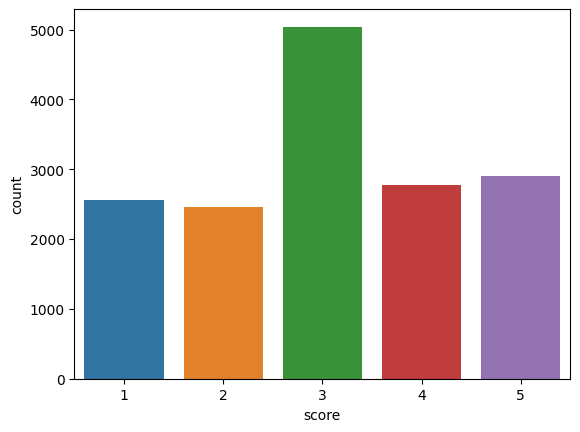

In [12]:
# ¿Cómo están balanceados los datos?
sns.countplot(x=df.score)

In [13]:
# Valores únicos de la columna 'score'
df.score.unique()

array([1, 2, 3, 4, 5])

In [14]:
# Genero una columna sentiment con valores obtenidos de la columna score
df['sentiment'] = df.score.map({1: 0, 2: 1, 3: 2, 4: 3, 5: 4})

In [15]:
df['sentiment'].unique()

array([0, 1, 2, 3, 4])

In [16]:
# Ahora tengo una columna 'sentiment' que tiene valores de 0 a 4
class_names = ['1', '2', '3', '4', '5']

## Limpieza de datos

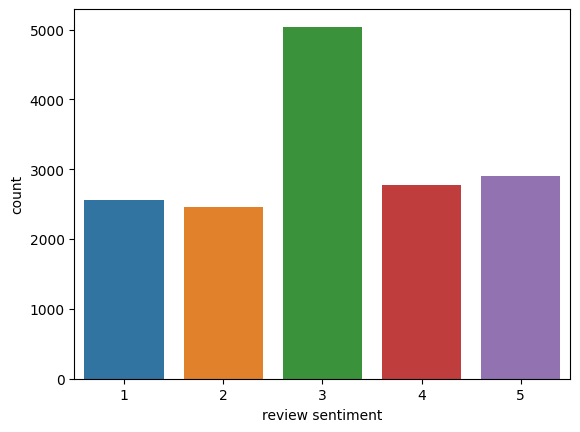

In [17]:
ax = sns.countplot(x='sentiment', data=df)
plt.xlabel('review sentiment')
# Ajustar las ubicaciones de los ticks
ax.set_xticks(range(len(class_names)))
ax.set_xticklabels(class_names);

In [18]:
sentences = df['content'].values
print("sentences shape:", sentences.shape)
sentences[:3]

sentences shape: (15746,)


array(["Update: After getting a response from the developer I would change my rating to 0 stars if possible. These guys hide behind confusing and opaque terms and refuse to budge at all. I'm so annoyed that my money has been lost to them! Really terrible customer experience. Original: Be very careful when signing up for a free trial of this app. If you happen to go over they automatically charge you for a full years subscription and refuse to refund. Terrible customer experience and the app is just OK.",
       'Used it for a fair amount of time without any problems. Suddenly then asked me to create an account or log using Google or FB. I used my Google one only to discover everything was gone!',
       "Your app sucks now!!!!! Used to be good but now doesn't update until I physically open it up and then close it then scroll and then it finally shows what I want to put on the list!!!!!! And I FRIGGEN paid for this garbage!!!!!!!"],
      dtype=object)

Median: 139.0


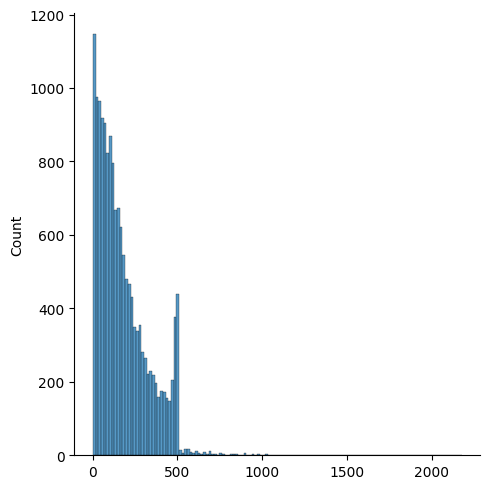

In [19]:
sentence_lens = []

for sentence in sentences:
  sentence_lens.append(len(sentence))

print("Median:", np.median(sentence_lens))
sns.displot(sentence_lens)

In [20]:
from tensorflow.keras.utils import to_categorical

In [21]:
y = df['sentiment'].values
print("y shape:", y.shape)
y = to_categorical(y)
print(y[:3])
output_shape = y.shape[1]
print("output shape:", output_shape)

y shape: (15746,)
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
output shape: 5


## 1 - Data generator


In [22]:
from transformers import InputExample, InputFeatures  # Métodos para transformar el dataset
from transformers import BertTokenizer


In [23]:
# Muy importante que para tensorflow los modelos Bert deben empezar con "TF"
# de lo contrario estaremos utilizando un modelo para pytorch

# Descargamos el modelo base de BERT más liviano y su correspondiente tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [24]:
# Del dataset original accederemos a los datos por índices (idx)
# mezclados aleatoriamente
from sklearn.model_selection import train_test_split
max_length = 140 # BERT soporta máximo 512
indices = np.arange(len(sentences))
idx_train_val, idx_test = train_test_split(indices, test_size=0.2, random_state=42)
idx_train, idx_val = train_test_split(idx_train_val, test_size=0.2, random_state=42)

In [25]:
print(idx_train.shape[0], idx_val.shape[0], idx_test.shape[0])

10076 2520 3150


In [26]:

def convert_data_to_examples(text, labels, idx_train, idx_val):
    # Armamos un "InputExample" para los datos de entrenamiento y validación
    train_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text[i], 
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_train]

    validation_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text[i],
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_val]
  
    return train_InputExamples, validation_InputExamples

 
def convert_examples_to_tf_dataset(examples, bert_tokenizer, max_length=512):
    # Transformamos los datos de entrada en tensorres de:
    # input_ids --> token id
    # attention_mask
    # token type
    features = []

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = bert_tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=False,
            return_attention_mask=True,
            padding='max_length', # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, attention_mask = (input_dict["input_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, label=e.label
            )
        )

    def gen():
    # Función generadora para no levantar todos los datos en un instante
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                },
                f.label,
            )

    return tensorflow.data.Dataset.from_generator(
        # Tensorflow dataset generator (basado en el generador y en el esquema de datos definido)
        gen,
        ({"input_ids": tensorflow.int32, "attention_mask": tensorflow.int32}, tensorflow.float32),
        (
            {
                "input_ids": tensorflow.TensorShape([None]),
                "attention_mask": tensorflow.TensorShape([None]),
            },
            tensorflow.TensorShape([output_shape]),
        ),
    )

In [27]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(sentences, y, idx_train, idx_val)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), bert_tokenizer, max_length=max_length)
# shuffle 100 --> mezcla los datos y los lee a de 100 unidades
# batch 32 --> ejecuta una epoca de entrenamiento de a 32 unidades
train_data = train_data.shuffle(100).batch(32)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), bert_tokenizer, max_length=max_length)
validation_data = validation_data.batch(32)

In [28]:
pred_sentences = [sentences[i] for i in idx_test]
tf_batch = bert_tokenizer(pred_sentences, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

In [29]:
X_test = [tf_batch['input_ids'],  
          tf_batch['attention_mask']]

In [30]:
y_test = y[idx_test]

Para tratar el desbalanceo de clases, usaré el argumento class_weight en el método fit del modelo de Keras. El cual permite asignar diferentes pesos a cada clase, de modo que las clases menos frecuentes tengan un mayor impacto en la función de pérdida durante el entrenamiento. 
Los pasos que haré son:

1. Calcular las frecuencias de cada clase.
2. Invertir las frecuencias para obtener los pesos.
3. Pasar estos pesos al método fit del modelo.

In [31]:
# Calcular pesos de clases
class_weights = dict(enumerate(np.max(np.bincount(df['sentiment'])) / np.bincount(df['sentiment'])))
print("Class weights:", class_weights)

Class weights: {0: 1.9649259547934528, 1: 2.0479285134037366, 2: 1.0, 3: 1.8162824207492796, 4: 1.7386206896551724}


## 2 - BERT multiclass classification

In [32]:
history1 = model.fit(train_data, epochs=5, validation_data=validation_data, class_weight=class_weights)

Epoch 1/5
      2/Unknown - 7s 89ms/step - loss: 3.3161 - accuracy: 0.2344 - f1_score_macro: 0.1541

2024-06-18 15:16:10.143983: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


315/315 [==============================] - 40s 107ms/step - loss: 2.5555 - accuracy: 0.2447 - f1_score_macro: 0.1962 - val_loss: 1.5739 - val_accuracy: 0.2921 - val_f1_score_macro: 0.2322
Epoch 2/5
315/315 [==============================] - 32s 101ms/step - loss: 2.3860 - accuracy: 0.3011 - f1_score_macro: 0.2588 - val_loss: 1.4607 - val_accuracy: 0.3167 - val_f1_score_macro: 0.2129
Epoch 3/5
315/315 [==============================] - 32s 102ms/step - loss: 2.2820 - accuracy: 0.3302 - f1_score_macro: 0.2886 - val_loss: 1.4135 - val_accuracy: 0.3294 - val_f1_score_macro: 0.2276
Epoch 4/5
315/315 [==============================] - 32s 101ms/step - loss: 2.2345 - accuracy: 0.3449 - f1_score_macro: 0.3079 - val_loss: 1.3663 - val_accuracy: 0.3675 - val_f1_score_macro: 0.3118
Epoch 5/5
315/315 [==============================] - 32s 100ms/step - loss: 2.1888 - accuracy: 0.3558 - f1_score_macro: 0.3198 - val_loss: 1.3729 - val_accuracy: 0.3718 - val_f1_score_macro: 0.3132


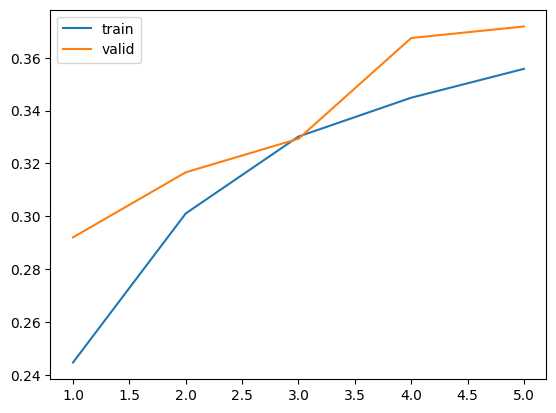

In [33]:
plot_train_metrics(history1)

In [34]:
y_hat_prob = model.predict(X_test)
y_hat_prob[:5] 

99/99 [==============================] - 9s 74ms/step


array([[0.3468324 , 0.29055092, 0.19551674, 0.10885606, 0.05824389],
       [0.20757918, 0.22736885, 0.21890487, 0.18840641, 0.15774074],
       [0.06225266, 0.1119819 , 0.19640101, 0.33004534, 0.2993191 ],
       [0.05623782, 0.09621116, 0.17307355, 0.31794426, 0.35653326],
       [0.1672283 , 0.21451683, 0.24201423, 0.2290192 , 0.14722152]],
      dtype=float32)

In [35]:
y_hat = np.argmax(y_hat_prob, axis=1)

In [36]:
# Calcular la exactitud (accuracy)
scores = model.evaluate(X_test, y_test)
scores[1]

99/99 [==============================] - 9s 74ms/step - loss: 1.3831 - accuracy: 0.3603 - f1_score_macro: 0.3083


0.3603174686431885

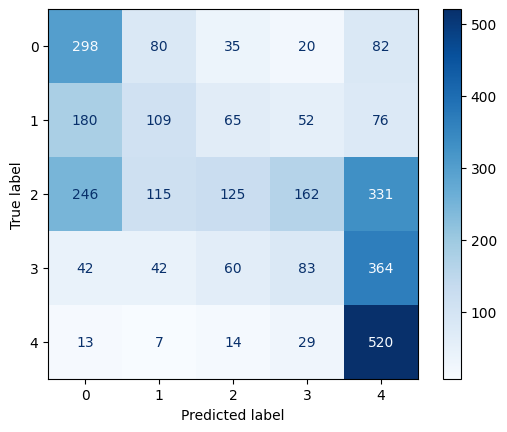

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test.argmax(axis=1), y_hat)
cmd = ConfusionMatrixDisplay(cm, display_labels=list(range(len(class_names))))
cmd.plot(cmap=plt.cm.Blues)
plt.show()

## 3 - BERT Fine tuning

In [38]:
model2 = model

# Colocar todas las layers como entrenables
for layer in model2.layers:
  layer.trainable = True

# Como es fine tunning se recomiendo utiliza al menos un learning rate 100 veces
# menor
model2.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy',f1_score_macro])


model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 140)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 140)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 140,                                           

In [39]:
#history2 = model2.fit(train_data, epochs=5, validation_data=validation_data)
history2 = model.fit(train_data, epochs=5, validation_data=validation_data, class_weight=class_weights)

Epoch 1/5
315/315 [==============================] - 83s 241ms/step - loss: 1.9084 - accuracy: 0.4470 - f1_score_macro: 0.4095 - val_loss: 1.1647 - val_accuracy: 0.4798 - val_f1_score_macro: 0.4345
Epoch 2/5
315/315 [==============================] - 74s 234ms/step - loss: 1.7002 - accuracy: 0.5110 - f1_score_macro: 0.4834 - val_loss: 1.0987 - val_accuracy: 0.5274 - val_f1_score_macro: 0.4971
Epoch 3/5
315/315 [==============================] - 74s 235ms/step - loss: 1.4931 - accuracy: 0.5759 - f1_score_macro: 0.5527 - val_loss: 1.0636 - val_accuracy: 0.5603 - val_f1_score_macro: 0.5344
Epoch 4/5
315/315 [==============================] - 74s 235ms/step - loss: 1.3015 - accuracy: 0.6348 - f1_score_macro: 0.6156 - val_loss: 1.0381 - val_accuracy: 0.5806 - val_f1_score_macro: 0.5609
Epoch 5/5
315/315 [==============================] - 74s 235ms/step - loss: 1.0856 - accuracy: 0.7025 - f1_score_macro: 0.6866 - val_loss: 1.1199 - val_accuracy: 0.6087 - val_f1_score_macro: 0.5872


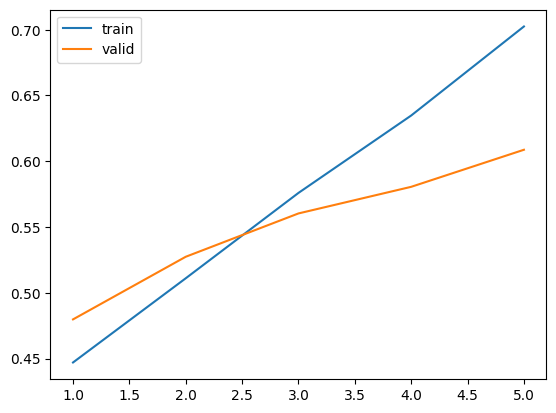

In [40]:
plot_train_metrics(history2)

In [41]:
y_hat_prob2 = model2.predict(X_test)
y_hat_prob2[:5]

99/99 [==============================] - 8s 73ms/step


array([[4.0896237e-02, 2.4820535e-01, 5.4339725e-01, 1.6475633e-01,
        2.7447613e-03],
       [3.0590561e-01, 5.9715706e-01, 9.3450993e-02, 3.3920219e-03,
        9.4327617e-05],
       [1.4804419e-03, 3.4350231e-02, 3.2842955e-01, 6.2167645e-01,
        1.4063327e-02],
       [3.2941898e-05, 1.5995828e-03, 7.3319264e-02, 8.9065194e-01,
        3.4396220e-02],
       [6.3479925e-03, 2.3644789e-01, 6.4264905e-01, 1.1434696e-01,
        2.0815911e-04]], dtype=float32)

In [42]:
y_hat2 = np.argmax(y_hat_prob2, axis=1)

In [43]:
# Calcular la exactitud (accuracy)
scores = model2.evaluate(X_test, y_test)
scores[1]

99/99 [==============================] - 9s 75ms/step - loss: 1.1137 - accuracy: 0.6038 - f1_score_macro: 0.5846


0.6038095355033875

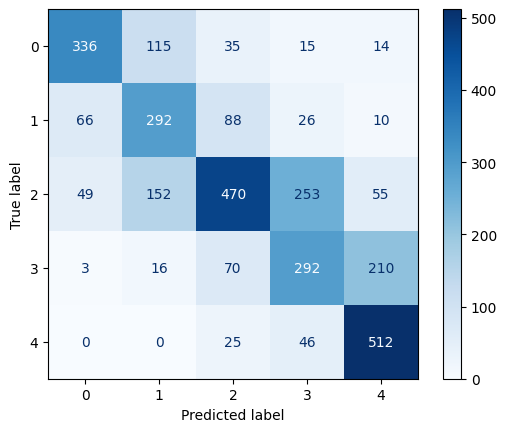

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test.argmax(axis=1), y_hat2)
cmd = ConfusionMatrixDisplay(cm, display_labels=list(range(len(class_names))))
cmd.plot(cmap=plt.cm.Blues)
plt.show()

## Salvar el modelo

In [45]:
model2.save_weights('bert_weights_jcv.h5')

In [46]:

# Descargar los pesos a nuestra PC
# Solo es necesario si se desea repetir el uso de este modelo en el futuro
#from google.colab import files
#files.download('bert_weights.h5')

## Levantar el modelo

In [47]:
bert_model3 = TFBertModel.from_pretrained("bert-base-uncased")

input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')

# attention_mask - is a binary mask which tells BERT which tokens to attend and which not to attend.
# Encoder will add the 0 tokens to the some sequence which smaller than MAX_SEQUENCE_LENGTH, 
# and attention_mask, in this case, tells BERT where is the token from the original data and where is 0 pad token:
attention_mask = tensorflow.keras.layers.Input((max_length,), dtype=tensorflow.int32, name='attention_mask')

# Get the pooled_output (embedding que representa toda la entrada)
#output = bert_model3([input_ids, attention_mask])[1] 
outputs = bert_model3(input_ids, attention_mask=attention_mask)
pooled_output = outputs.pooler_output
dense = tensorflow.keras.layers.Dense(128, activation='relu')(pooled_output)
x = tensorflow.keras.layers.Dropout(0.2)(dense)


# We can also add dropout as regularization technique:
output = tensorflow.keras.layers.Dropout(rate=0.2)(x)

# Se puede agregar más capas Densas en el medio si se desea

# Provide number of classes to the final layer:
output = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(output)

# Final model:
model3 = tensorflow.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [48]:
# Cargo los pesos del modelo entrenado
model3.load_weights('bert_weights_jcv.h5')

## Ensayo

In [49]:
text = "I love this app!"

#tf_batch = bert_tokenizer(text, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length, # truncates if len(s) > max_length
    return_token_type_ids=False,
    return_attention_mask=True,
    pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
    truncation=True,
    return_tensors='tf'
)

print("Inputs ids:", tf_batch['input_ids'])
print("Attention mask:", tf_batch['attention_mask'])

Inputs ids: tf.Tensor(
[[  101  1045  2293  2023 10439   999   102     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]], shape=(1, 140), dtype=int32)
Attention mask: tf.Tensor(
[[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

/home/jorge/miniconda3/envs/tensorflow/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [50]:
X_ensayo = [tf_batch['input_ids'],  
          tf_batch['attention_mask']]

In [51]:
y_prob_ensayo = model3.predict(X_ensayo)
y_prob = np.argmax(y_prob_ensayo, axis=1)
print("Clasificación:", class_names[int(y_prob)])

1/1 [==============================] - 1s 1s/step
Clasificación: 5


## Conclusiones

Se puede apreciar que luego de realizar el fine tuning el modelo se ajusta mucho mejor al problema. Existen diferentes formas de llevar a cabo este proceso, es importante que el learning rate sea mucho menor.\
Existen optimizadores pensados para fine tuning que realizan el ajuste de learning rate adaptativo a medida que se va entrenando capas más profundas del modelo.